# crc_scripts Snapshot Read-In and Analysis Tutorial

This short Jupyter notebook will walk you through some examples for how to use my scripts to read in GIZMO snapshot data and create a few plots.

In [1]:
%load_ext autoreload
%autoreload 2

import crc_scripts.io.gizmo as gizmo

## Reading Snapshots (Basics)

This walks you through the very basics for reading snapshots without explaining what's going on under the hood. If you want to know more details check out the Reading Snapshots (Advanced) section.

### Initializing snapshot objects

Here we will choose which snapshot to read and initialize our object.

In [2]:
# This is the directory of the simulation you want to read snapshots from
# The default simulation directory layout is SIMULATION_NAME/output/ with the snapshots being stored in the output folder.
sim_dir= '/N/project/choban_group/present_day_suite/m12i_res7100/'
snap_dir = sim_dir + 'output/'
# This is the number of the snapshot you want to read
snap_num = 600

# Is the simulation you are reading a cosmological simulation? 1 for yes, 0 for no.
cosmological = 1

# Now load in the snapshot
halo = gizmo.load_halo(snap_dir, snap_num, cosmological=cosmological)

/N/project/choban_group/present_day_suite/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
No halo file given so galaxy centered on median position of gas particles with nH>10 cm^-3. This may not always work.


The above code should tell you the exact snapshot file name it is reading and that no halo file is found.

If it tells you the file does not exist, make sure you are pointing to the correct directory.

### Centering your galaxy

In cosmological simulations, the main galaxy could be almost anywhere in the simulation volume. Here we will center the galaxy at the origin of our coordinates and align the galaxy so it is face on, meaning for a disk galaxy the disk will lie in the x-y plane.


In [3]:

# We first set how much of the galaxy you want to zoom in on. Default is 10 kpc.
halo.set_zoom()

# Now we set the orientation of the galaxy. This will place the center of the galaxy at the coordinate origin and rotate it to be face on.
halo.set_orientation()

assigning center of galaxy:
  center position [kpc] = 41821.601, 44186.981, 46265.911
  center velocity [km/s] = -51.9, 75.5, 94.7
assigning principal axes:
  using ptype 4 particles at radius < 10 kpc
  using ptype 4 particles with age = [0, 1] Gyr
  axis ratios:  min/maj = 0.127, min/med = 0.132, med/maj = 0.963


Let's confirm we are centered on our galaxy by making a x-y and y-z projection plot of the gas, stars, and dust in our beautiful spiral galaxy. 
You don't need to understand how this works.

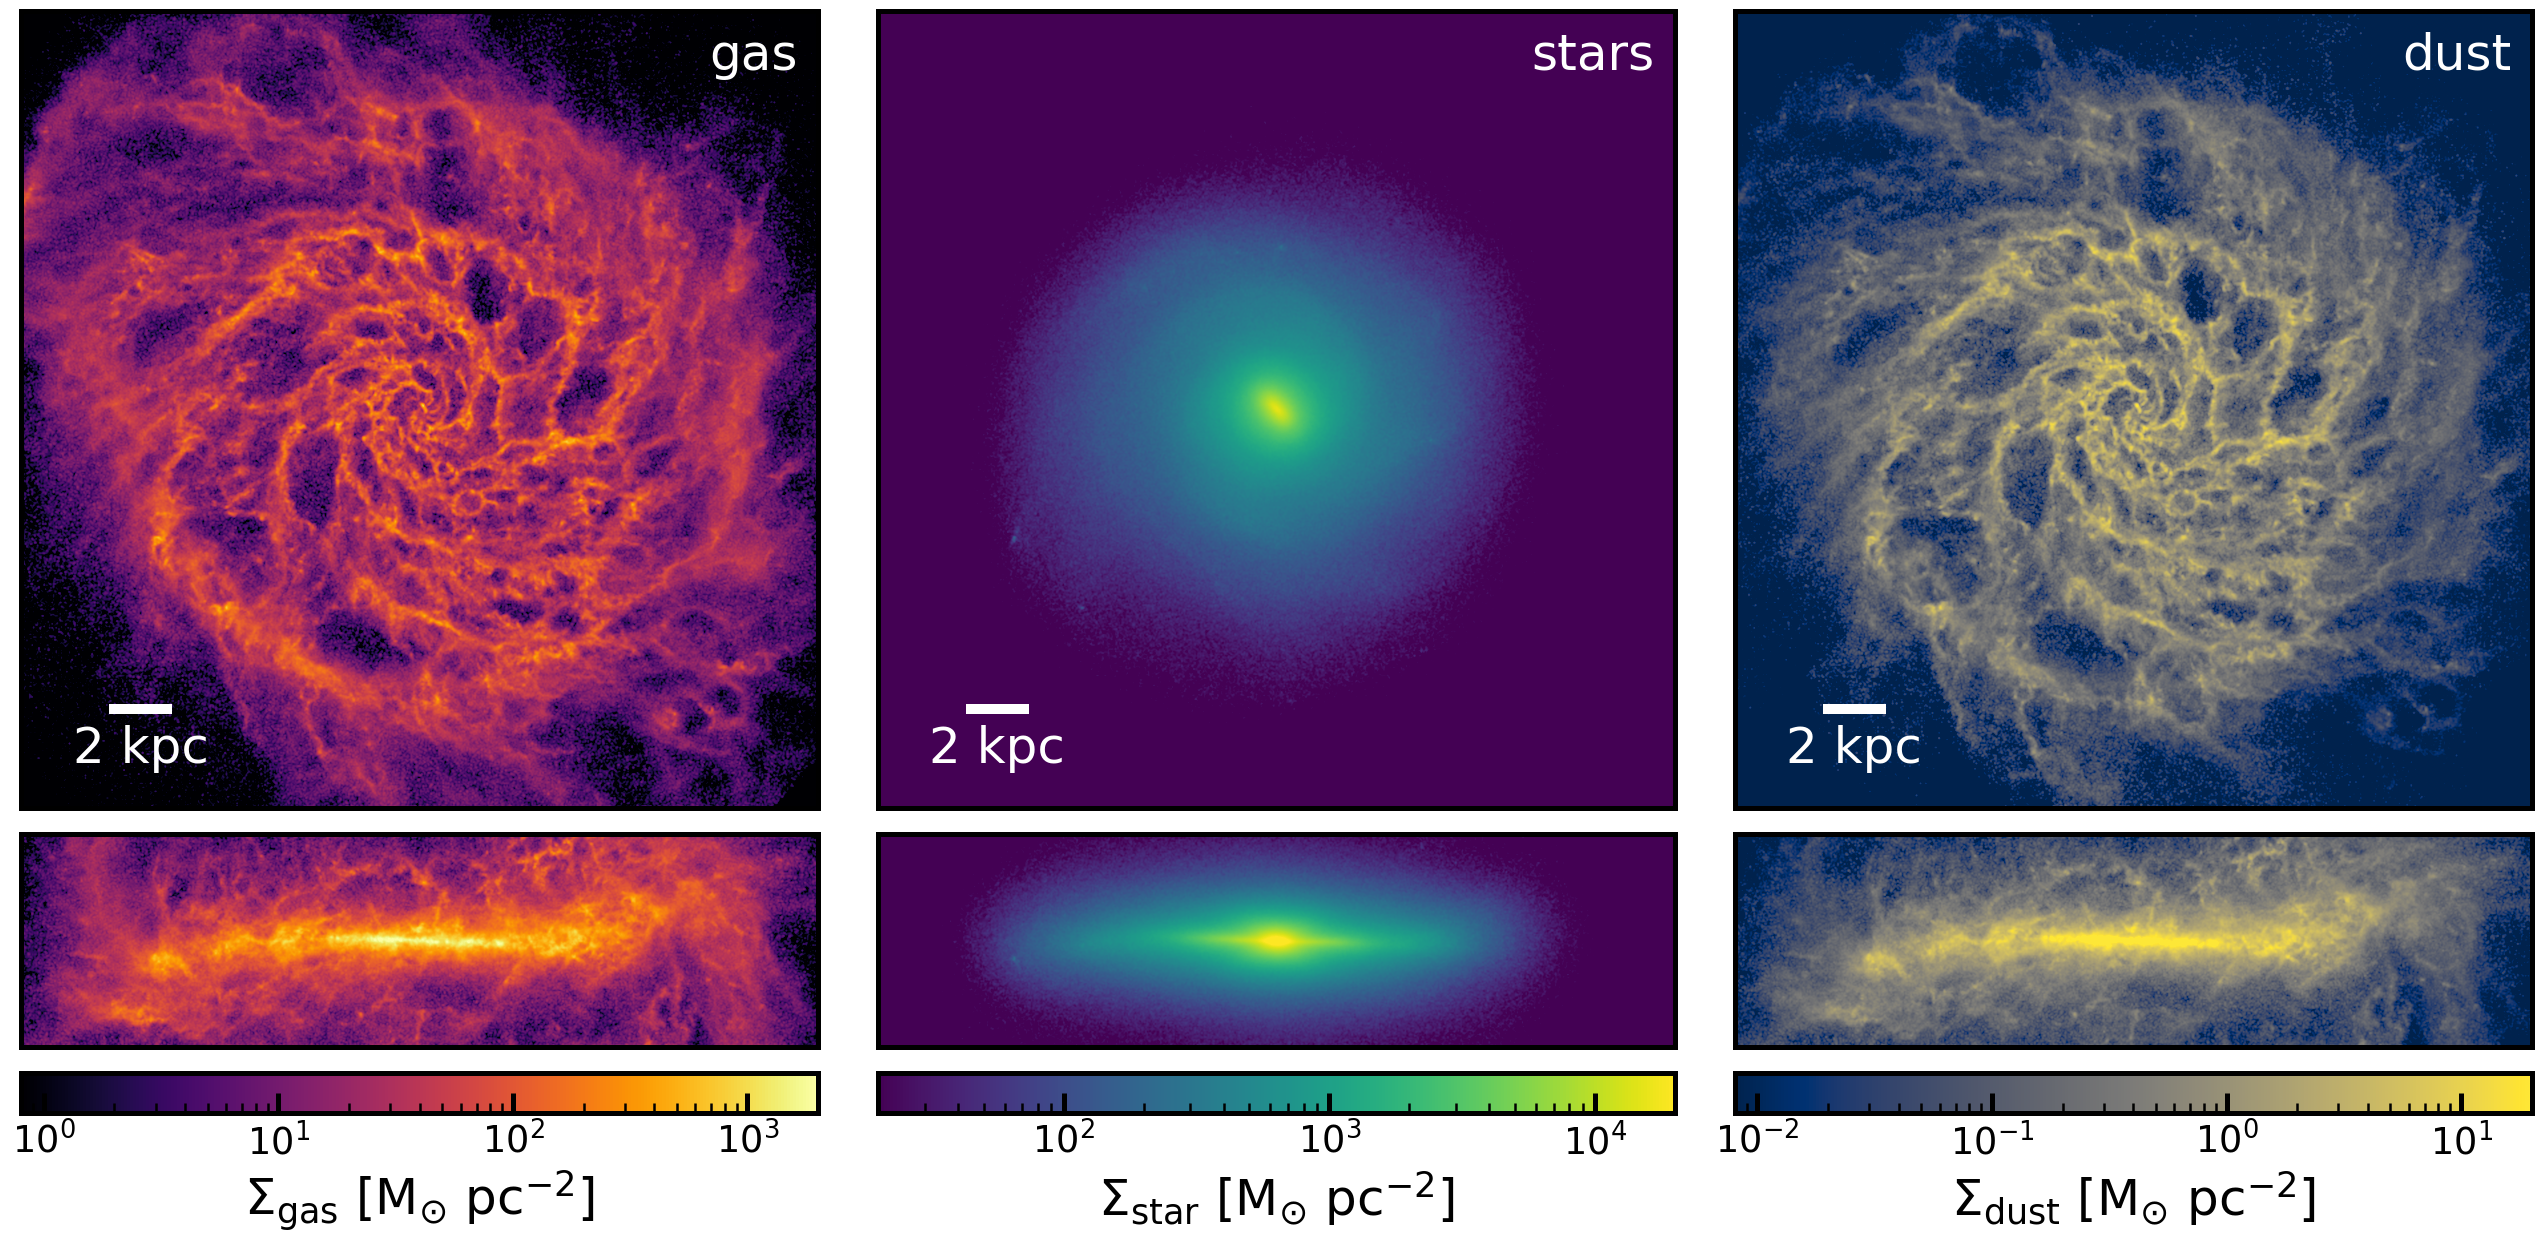

In [4]:
# These are used for making a simple projection. If you only want to lad snapshot data you don't need to use these
from crc_scripts.figure import Projection
import crc_scripts.utils.data_calc_utils as calc

# Set a bunch of parameters for the projection plot

# Physical size of projection 
proj_L = 15 # kpc
# Size resolution (kpc) for each "pixel" in projection
pixel_res=0.05
# Properties to plot projections of. Can be surface densities (total mass in pixel divied by pixel size) or properties like T (median value of all particles in pixel)
properties = ['sigma_gas','sigma_star','sigma_dust']
# Limits for projection of each property. Defaults if not set
prop_limits = [[8E-1,2E3],[2E1,2E4],[8E-3,2E1]]
# Colormaps for each projection
prop_cmaps = ['inferno','viridis','cividis']
# Do you want log colormaps for each property (default = True)
log_cmaps = [True]*len(properties)
# Labels for each projection is so desired
labels = ['gas','stars','dust']
# Physical size of projection 
proj_L = 30 # kpc
# Do you want a secondary projection from an orthogonal axis (i.e. edge-on)
sub_proj = True
# size of secondary projection
sub_L = 8 # kpc



# Initialize projection figure
L = proj_L
height_ratios = [L/sub_L,1]
new_proj = Projection(len(properties), add_sub_proj=sub_proj, add_colorbars=True, height_ratios=height_ratios)
# Create projections for each property and plot the projection
for j,prop in enumerate(properties):
    new_proj.set_proj_axis(j, prop, L, axes_visible=False)
    # Create x-y projection using a 2D histogram
    main_pixel_stats, main_xedges, main_yedges, main_extent = calc.calc_projected_prop(prop, halo, [L,L,L], pixel_res=pixel_res, proj='xy')
    if sub_proj:
        # Create x-z subprojection using a 2D histogram
        sub_pixel_stats, sub_xedges, sub_yedges, sub_extent = calc.calc_projected_prop(prop, halo, [L,sub_L,L], pixel_res=pixel_res, proj='xz')
    else:
        sub_pixel_stats=None; sub_extent=None
    # x-z projection
    # Create the projection
    if labels is not None:
        label = labels[j]
    else:
        label=None
    new_proj.plot_projection(j, main_pixel_stats, main_extent, sub_proj_data=sub_pixel_stats, sub_extent=sub_extent,
                                cmap= prop_cmaps[j], v_limits = prop_limits[j],v_log=log_cmaps[j], label=label)



### Data analysis
Now that you have loaded your snapshot, you may want to get the useful data stored within to do some analysis. 
For FIRE simulations, gas and stars are treated as particles and so the snapshots store information about each particles such as coordinates, mass, velocity and so much more.

Gas particles are denoted by the identifier ptype=0 and stars are ptype=4. Below we load in star and gas particle data.

In [5]:
gas = halo.loadpart(0)
star = halo.loadpart(4)

The gas particle data is stored in the Particle object gas and the star data is stored in the Particle object star. You can access the raw data vai the gas.data or star.data dictionary. All data is stored in typical astronomy units such as solar masses, parsecs, km/s, K, etc.

In [6]:
# Lets see what data is stored in the snapshot for gas and star particles
print(gas.data.keys())
print(star.data.keys())
# Get the gas particle mass data.
print(gas.data['mass'])


dict_keys(['id', 'position', 'velocity', 'mass', 'temperature', 'density', 'size', 'electron_fraction', 'H_neutral_fraction', 'H2_fraction', 'sfr', 'id_child', 'id_generation', 'Z', 'dust_Z', 'dust_source'])
dict_keys(['id', 'position', 'velocity', 'mass', 'id_child', 'id_generation', 'Z', 'sft', 'age'])
[ 7684.1987 15644.567   8727.321  ... 11941.025  12836.026   8625.55  ]


Now get out there and do some analysis!

## Reading Snapshots (Advanced)
This walks you through the how to read in snapshots, explains exactly what each function is doing, and what optional parameters you can set for each.

### Initializing snapshot objects

Here we will choose which snapshot to read and initialize our object.

In [7]:
# This is the directory of the simulation you want to read snapshots from
# The default simulation directory layour is SIMULATION_NAME/output/ with the snapshots being stored in the output folder.
sim_dir= '/N/project/choban_group/present_day_suite/m12i_res7100/'
snap_dir = sim_dir + 'output/'
# This is the number of the snapshot you want to read
snap_num = 600

# If you have halo finder files (like amiga halo finder) you can specify the directory.
# These files are used to center the galaxy using the center of the dark matter halo. If this is set to None, then the galaxy will be picked from the mean position of young stars.
# Halo files are useful if you want to pick out a subhalo or the main halo at early times when the most massive halo may not be the main halo at simulation end.
# halo_dir = sim_dir + '/halo/ahf/output/'
# halo_ID=-1
# mode = 'AHF

# Is the simulation you are reading a cosmological simulation? 1 for yes, 0 for no.
cosmological = 1

# Now load in the snapshot
halo = gizmo.load_halo(snap_dir, snap_num, cosmological=cosmological)

/N/project/choban_group/present_day_suite/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
No halo file given so galaxy centered on median position of gas particles with nH>10 cm^-3. This may not always work.


The above code should tell you the exact snapshot file name it is reading and that no halo file is found.

We won't explore halo files here, but just know they can be used to accurately center onto a specific galaxy halo. For now the code is instead using the center position of dense gas, which should be a decent approximation in most cases.


If it tells you the file does not exist, make sure you are pointing to the correct directory.

### Centering your galaxy

In cosmological simulations, the main galaxy could be almost anywhere in the simulation volume. Here we will center the galaxy at the origin of our coordinates and align the galaxy so it is face on, meaning for a disk galaxy the disk will lie in the x-y plane.


In [8]:

# We first set how much of the galaxy you want to zoom in on. 
# This function will set a sphere with a specified radius centered at the origin and only include particles within that radius
# You can either set kpc = False and treat rout as the fraction of the virial radius (typical galaxy are around 10-20% R_virial), this only works if you have an halo file since it provides R_virial, or set kpc = True and treat rout as the radius in kpc (for reference MW is ~10 kpc in radius) you want to zoom in on.
halo.set_zoom(rout = 20, kpc=True)

# Now we set the orientation of the galaxy. This will center the galaxy at the origin and rotate it so that the angular momentum vector is aligned with the z-axis.
# This function first finds the exact center and velocity of the galaxy by using a shrinking sphere algorithm where it finds the center of mass of the particles within a sphere (starting with radius mass_radius_max) and then shrinks the sphere until the center of mass is stable.
# Then it determines the angular momentum vector of the galaxy by calculating the average angular momentum of young star particles (ptype=4; age_limits = 0 to 1 Gyr) with a specified radius (radius_max) of the center of the galaxy.
# This will output the coordinates and velocity of the galactic center is and the normal of the angular momentum vector.
halo.set_orientation(ptype=4, mass_radius_max = 100, velocity_radius_max=15, radius_max=10, age_limits=[0,1])

assigning center of galaxy:
  center position [kpc] = 41821.601, 44186.981, 46265.911
  center velocity [km/s] = -51.9, 75.5, 94.7
assigning principal axes:
  using ptype 4 particles at radius < 10 kpc
  using ptype 4 particles with age = [0, 1] Gyr
  axis ratios:  min/maj = 0.127, min/med = 0.132, med/maj = 0.963


Let's confirm we are centered on our galaxy by making a x-y and y-z projection plot of the gas, stars, and dust in our beautiful spiral galaxy. 
You don't need to understand how this works.

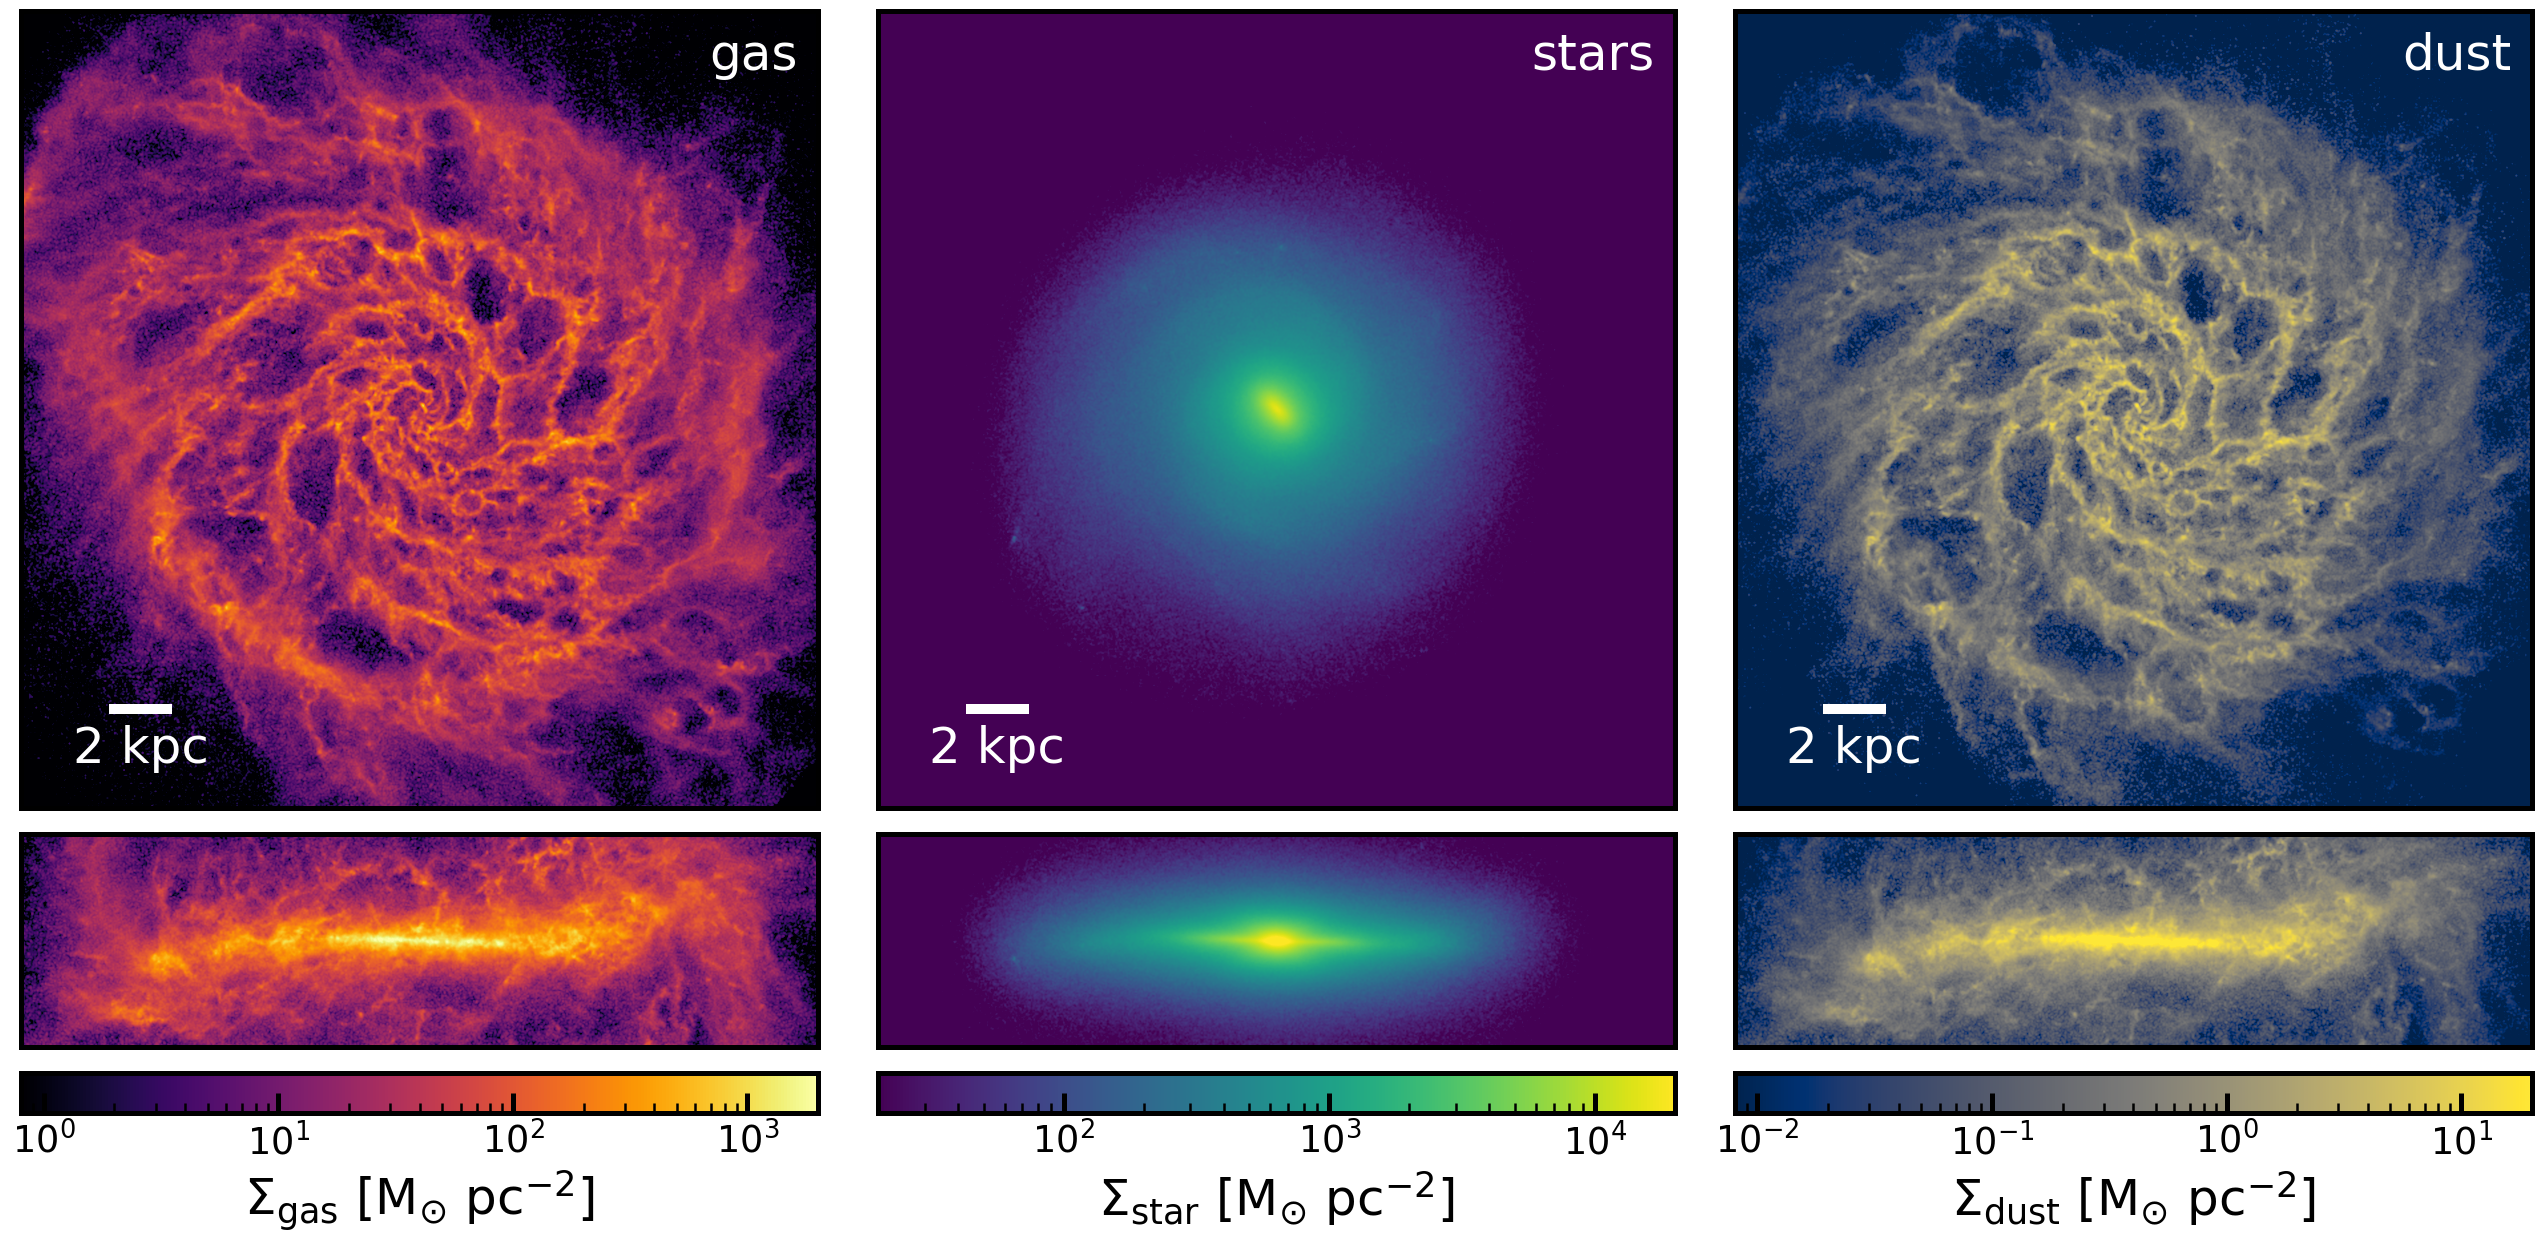

In [9]:
# These are used for making a simple projection. If you only want to lad snapshot data you don't need to use these
from crc_scripts.figure import Projection
import crc_scripts.utils.data_calc_utils as calc


# Set a bunch of parameters for the projection plot

# Physical size of projection 
proj_L = 15 # kpc
# Size resolution (kpc) for each "pixel" in projection
pixel_res=0.05
# Properties to plot projections of. Can be surface densities (total mass in pixel divied by pixel size) or properties like T (median value of all particles in pixel)
properties = ['sigma_gas','sigma_star','sigma_dust']
# Limits for projection of each property. Defaults if not set
prop_limits = [[8E-1,2E3],[2E1,2E4],[8E-3,2E1]]
# Colormaps for each projection
prop_cmaps = ['inferno','viridis','cividis']
# Do you want log colormaps for each property (default = True)
log_cmaps = [True]*len(properties)
# Labels for each projection is so desired
labels = ['gas','stars','dust']
# Physical size of projection 
proj_L = 30 # kpc
# Do you want a secondary projection from an orthogonal axis (i.e. edge-on)
sub_proj = True
# size of secondary projection
sub_L = 8 # kpc



# Initialize projection figure
L = proj_L
height_ratios = [L/sub_L,1]
new_proj = Projection(len(properties), add_sub_proj=sub_proj, add_colorbars=True, height_ratios=height_ratios)
# Create projections for each property and plot the projection
for j,prop in enumerate(properties):
    new_proj.set_proj_axis(j, prop, L, axes_visible=False)
    # Create x-y projection using a 2D histogram
    main_pixel_stats, main_xedges, main_yedges, main_extent = calc.calc_projected_prop(prop, halo, [L,L,L], pixel_res=pixel_res, proj='xy')
    if sub_proj:
        # Create x-z subprojection using a 2D histogram
        sub_pixel_stats, sub_xedges, sub_yedges, sub_extent = calc.calc_projected_prop(prop, halo, [L,sub_L,L], pixel_res=pixel_res, proj='xz')
    else:
        sub_pixel_stats=None; sub_extent=None
    # x-z projection
    # Create the projection
    if labels is not None:
        label = labels[j]
    else:
        label=None
    new_proj.plot_projection(j, main_pixel_stats, main_extent, sub_proj_data=sub_pixel_stats, sub_extent=sub_extent,
                                cmap= prop_cmaps[j], v_limits = prop_limits[j],v_log=log_cmaps[j], label=label)



### Data analysis
Now that you have loaded your snapshot, you may want to get the useful data to do some analysis. 
For FIRE simulations, gas and stars are treated as particles and so the snapshots store information about each particles such as coordinates, mass, velocity and so much more.

Gas particles rae denoted by the identifier ptype=0 and star particles denoted by ptype=4.
To load particle information, use the loadpart(ptype) function as shown below.

In [10]:
gas = halo.loadpart(0)
star = halo.loadpart(4)

Now all the gas particle data is stored in the Particle object gas and the star particle data is stored in Particle object star. You can access the raw data via the gas.data and star.data dictionaries. All data is stored in typical astronomy units such as solar masses, parsecs, km/s, K, etc. Note that snapshot data is stored in code units so the conversion to more useful units has already been done for you. Also, simple derived quantites such as conversion from interal energy to temperature and star formation time to age are also done for you.

In [11]:
# Lets see what data is stored in the snapshot for gas particles
print(gas.data.keys())
print(star.data.keys())
# Get the gas particle mass data.
print(gas.data['mass'])

dict_keys(['id', 'position', 'velocity', 'mass', 'temperature', 'density', 'size', 'electron_fraction', 'H_neutral_fraction', 'H2_fraction', 'sfr', 'id_child', 'id_generation', 'Z', 'dust_Z', 'dust_source'])
dict_keys(['id', 'position', 'velocity', 'mass', 'id_child', 'id_generation', 'Z', 'sft', 'age'])
[ 7684.1987 15644.567   8727.321  ... 11941.025  12836.026   8625.55  ]


If you want a more handy way of getting the data, you can use the Particle get_property(prop_name) function. This can give you the raw data as previously shown, and simple derived data products such as number density from mass density, or mass of metals from metallicity and particle mass.

Note that the derived property you want may not be supported by get_property() or requires a specified key word (check the function to see what's supported), but you can always add it. 

Let's load the temperature (in units of K) and hydrogen number density $n_{\rm H}$ (in units of ${\rm cm}^{-3}$ ) data for all gas particles.

In [12]:
print(gas.get_property('temperature'))
print(gas.get_property('nH'))

[6.1222271e+03 1.1252230e+02 3.3109543e+02 ... 9.3469854e+03 1.9988732e+03
 1.0808640e+06]
[0.12965788 1.6145524  0.64416057 ... 1.5147327  2.1341436  0.48003745]


Now let's load something thats not supported, like the HII mass.

In [13]:
gas.get_property('HII_mass')

Property HII_mass given to Particle with ptype 0 is not supported. Returning -1 array.


array([-1., -1., -1., ..., -1., -1., -1.])

A good exercise it to load the number density (prop_name = nH output in units of cm^-3) and temperature (prop_name = temperature or T output in units of K) and  data and plot a 2D histogram. This is called a gas phase plot. 

Try to make such a plot in the space below.

General limits should be T = 1-10^7 K and nH = 0.01-10^4 cm^-3.